# Topic Analysis
In this notebook I use negative review predictions from the modeling stage to perform topic analysis and identify keywords for the negative reviews. I will the text ranker **`networkx`** to carry out this analysis. Also, I will use a word cloud to visualize the main topics in the reviews.

## Setup

In [0]:
from google.colab import drive
from importlib.machinery import SourceFileLoader
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import os
import pandas as pd
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
import spacy
from wordcloud import WordCloud

%matplotlib inline

Mount Google Drive.

In [0]:
ROOT = '/content/drive'
PROJECT = 'My Drive/DataScience/Projects/GitHub/Achieving-Restaurant-Success'
PROJECT_PATH = os.path.join(ROOT, PROJECT)

In [3]:
# drive.mount(ROOT)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


Load custom methods and constants.

In [4]:
con = SourceFileLoader('constants', os.path.join(PROJECT_PATH, 'utilities/constants.py')).load_module()
met = SourceFileLoader('methods', os.path.join(PROJECT_PATH, 'utilities/methods.py')).load_module()

Instructions for updating:
If using Keras pass *_constraint arguments to layers.


## Load Data
Load the review text for reviews classified as negative.

In [0]:
df_negative = pd.read_csv(os.path.join(PROJECT_PATH, 'data/negative_review_predictions.csv'))

In [6]:
df_negative.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 621 entries, 0 to 620
Data columns (total 3 columns):
text_seq    621 non-null object
labels      621 non-null int64
text        621 non-null object
dtypes: int64(1), object(2)
memory usage: 14.7+ KB


## Data Preparation
There are a few data preparation steps that need to be taken before performing topic analysis. I will first tokenize the reviews. Then, I will tag the parts-of-speech for each token. During the modeling stage, I will explore how parts-of-speech affect the prediction of topics relavent to negative reviews.

In [0]:
# Load Spacy's toolset
nlp = spacy.load("en_core_web_sm")

In [0]:
def clean_data(df):
  df['tokens'] = df['text'].apply(lambda x: [y.text for y in nlp(x) if not y.is_stop and y.text.isalpha()])
  df['pos'] = df['text'].apply(lambda x: [y.pos_ for y in nlp(x) if not y.is_stop and y.text.isalpha()])

In [0]:
clean_data(df_negative)

In [20]:
df_negative.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 621 entries, 0 to 620
Data columns (total 5 columns):
text_seq    621 non-null object
labels      621 non-null int64
text        621 non-null object
tokens      621 non-null object
pos         621 non-null object
dtypes: int64(1), object(4)
memory usage: 24.4+ KB


Combine all reviews together into a single list, which will be the corpus of text.

In [0]:
corpus = []
for review in df_negative['tokens'].values:
  corpus += review

In [22]:
print(f'The corpus of negative reviews contains {len(corpus)} words.')

The corpus of negative reviews contains 33865 words.


Create a list of only the unique words, which will be the vocabulary.

In [0]:
vocab = list(set(corpus))

In [25]:
print(f'The corpus vocabulary size is {len(vocab)} words.')

The corpus vocabulary size is 6469 words.


In [26]:
df_negative['text'].values[:5]

array(["I have eaten at T and A's maybe 20 times and enjoy the old school family setting , photos, pastas and sausages here! I actually met the owner through my Mobil Headlamp restoration business and went to his house to restore his car \xa0lenses! After I found out he was the owner I went here with my family and entailed and Inhaled a plate of linguini and clams with the white sauce. Went back for some pizza with my daughter \xa0and ravioli with the Mrs.Came Back as recently as last week and chatted with Al for s bit while slurping some red sauce down with spaghetti! I will return to open the surprise envelope they grace all patrons last week and take down some more Italian joy! \xa0 and such! \xa0Then run an extra 13 miles that week \xa0. Thanks Al see yah soon !",
       'I stop by this place for get the avocado shake. Most of the people in there smoke, smoke are everywhere even though the sign said do not smoke. The 3 girls are not too friendly, sitting there for an hour drinking 

### Parts-of-Speech
When searching for relavent words, I will try filtering the text in a few different ways.

#### Exclude adjectives
First, I will remove all adjectives from the reviews, keeping the rest of the text.

In [0]:
def filter_adjectives(tokens, pos):
  filtered = []
  for x, y in zip(tokens, pos):
    if y != 'ADJ':
      filtered.append(x)
  return ' '.join(filtered)

In [0]:
df_negative['no_adjectives'] = df_negative.apply(lambda x: filter_adjectives(x['tokens'], x['pos']), axis=1)

In [31]:
df_negative['no_adjectives'].values[:5]

array(['eaten T maybe times enjoy school family setting photos pastas sausages actually met owner Mobil Headlamp restoration business went house restore car lenses found owner went family entailed Inhaled plate clams sauce Went pizza daughter ravioli Mrs Came recently week chatted Al s bit slurping sauce spaghetti return open surprise envelope grace patrons week joy run miles week Thanks Al yah soon',
       'stop place shake people smoke smoke sign said smoke girls sitting hour drinking shake come fill ice tea bathroom use piece paper open door',
       'come eat usually service Tonight story waiters wait half hour told majority orders cooked waiter audacity ask want cancel orders kids starving point course cancelled orders went restaurant close buy kids food customer service experienced service restaurant says lot eat waiters checked wave thing forks vegetables etc wait remind service owner having dinner friends tables away service experienced tonight lack thereof return',
       'Wa

Next, I will only keep the nouns, removing all other words from the reviews.

In [0]:
def only_nouns(tokens, pos):
  filtered = []
  for x, y in zip(tokens, pos):
    if y == 'NOUN':
      filtered.append(x)
  return ' '.join(filtered)

In [0]:
df_negative['only_nouns'] = df_negative.apply(lambda x: only_nouns(x['tokens'], x['pos']), axis=1)

In [34]:
df_negative['only_nouns'].values[:5]

array(['times school family setting photos pastas sausages owner restoration business house car lenses owner family plate clams sauce pizza daughter week bit sauce spaghetti surprise envelope patrons week joy miles week Thanks',
       'place shake people smoke smoke sign girls hour shake ice tea bathroom piece paper door',
       'service Tonight story waiters hour majority orders waiter audacity orders kids point course orders restaurant kids food customer service service restaurant lot waiters thing forks vegetables service owner dinner friends tables service tonight lack',
       'Way order Mushroom lettuce rib portion lettuce',
       'night city hostess Note minutes list'], dtype=object)

## Relevant Words
I will convert the text into TF-IDF vectors. This will allow me to define cutoffs at document frequency to exclude words that are used more commonly.

Before defining a cutoff, let's look at a distribution in inverse document frequency.

In [0]:
vectorizer = TfidfVectorizer()
vectorizer.fit(df_negative['text'].values)
idf = vectorizer.idf_
vectorizer.fit(df_negative['text'].values)
encodings = vectorizer.transform(df_negative['text'].values)

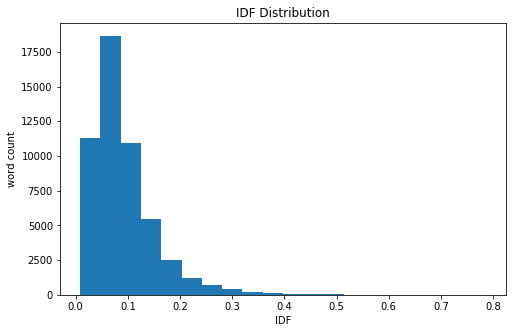

In [36]:
encodings_array = encodings.toarray()
encodings_flat = encodings_array.flatten()
fig, ax = plt.subplots(figsize=(8, 5))
ax.hist(encodings_flat[encodings_flat > 0], bins=20)
ax.set_title('IDF Distribution')
ax.set_xlabel('IDF')
ax.set_ylabel('word count')
plt.savefig(os.path.join(PROJECT_PATH, 'images/idf_distribution.png'))
plt.show()

Now, I will define a document frequency cutoff of 0.1. This means I will exclude words that are used more than 10% of the time.

In [0]:
vectorizer = TfidfVectorizer(max_df=0.1)
vectorizer.fit(df_negative['text'].values)
idf = vectorizer.idf_
stop_words = vectorizer.stop_words_
vectorizer.fit(df_negative['text'].values)
encodings = vectorizer.transform(df_negative['text'].values)

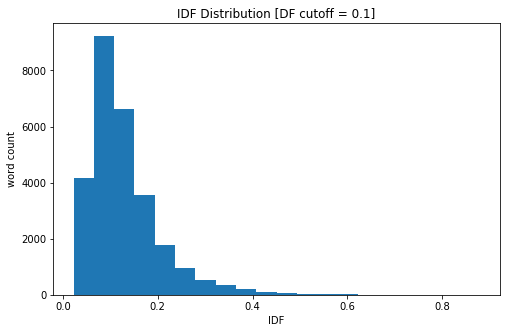

In [38]:
encodings_array = encodings.toarray()
encodings_flat = encodings_array.flatten()
fig, ax = plt.subplots(figsize=(8, 5))
ax.hist(encodings_flat[encodings_flat > 0], bins=20)
ax.set_title('IDF Distribution [DF cutoff = 0.1]')
ax.set_xlabel('IDF')
ax.set_ylabel('word count')
plt.savefig(os.path.join(PROJECT_PATH, 'images/idf_distribution_df_cutoff_01.png'))
plt.show()

### Predict Topics
Gather the vocabulary into a list.

In [0]:
vocab = [x for x,y in vectorizer.vocabulary_.items()]

In [40]:
print(f'The TF-IDF vocabulary size is {len(vocab)} words.')

The TF-IDF vocabulary size is 5968 words.


In [41]:
print(f'The first few words of the vocabular are: {vocab[:5]}')

The first few words of the vocabular are: ['eaten', 'maybe', '20', 'enjoy', 'old']


#### Adjacency
For each word in the corpus, keep track of that word and the neighbors around it.

In [0]:
df_adjacency = pd.DataFrame(columns=vocab, index=vocab, data=0)

Remove corpus-specific stop words.

In [0]:
corpus_clean = [x.lower() for x in corpus if x.lower() in vocab]

In [44]:
print(f'The corpus size is now {len(corpus_clean)} words.')

The corpus size is now 27019 words.


In [0]:
for i, word in enumerate(corpus_clean):
  end = max(0, len(corpus_clean) - (len(corpus_clean) - (i+5)))
  neighbors = corpus_clean[i+1: end]
  if neighbors:
      df_adjacency.loc[word, neighbors] = df_adjacency.loc[word, neighbors] + 1

#### Text Rank
Calculate TextRank using networkx.

In [0]:
nx_words = nx.from_numpy_matrix(df_adjacency.values)
ranks = nx.pagerank(nx_words, alpha=.85, tol=.00000001)

In [0]:
rankings_dict = {
    'rank': [],
    'word': []
}

In [0]:
for i, s in enumerate(vocab):
  rankings_dict['rank'].append(ranks[i])
  rankings_dict['word'].append(s)

In [0]:
df_rankings = pd.DataFrame(rankings_dict)

In [0]:
df_rankings.sort_values(by='rank', ascending=False, inplace=True)
df_rankings.index = np.arange(len(df_rankings))

In [51]:
df_rankings.head(n=10)

,rank,word
0,0.002476,server
1,0.002245,quality
2,0.002223,soup
3,0.002200,day
4,0.002165,wanted
5,0.002162,review
6,0.002116,salad
7,0.002050,going
8,0.002048,right
9,0.002033,lot


These words appear to vague. They don't point out specific areas where a restaurant could improve.

### No Adjectives
Repeat the analysis as above, but now remove all of the adjectives.

In [0]:
vectorizer = TfidfVectorizer()
vectorizer.fit(df_negative['no_adjectives'].values)
idf = vectorizer.idf_
vectorizer.fit(df_negative['no_adjectives'].values)
encodings = vectorizer.transform(df_negative['no_adjectives'].values)

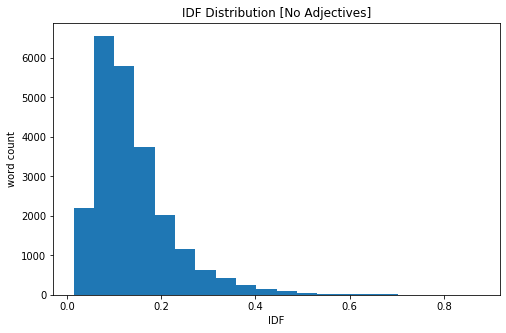

In [53]:
encodings_array = encodings.toarray()
encodings_flat = encodings_array.flatten()
fig, ax = plt.subplots(figsize=(8, 5))
ax.hist(encodings_flat[encodings_flat > 0], bins=20)
ax.set_title('IDF Distribution [No Adjectives]')
ax.set_xlabel('IDF')
ax.set_ylabel('word count')
plt.savefig(os.path.join(PROJECT_PATH, 'images/idf_distribution_no_adjectives.png'))
plt.show()

In [0]:
vocab = [x for x,y in vectorizer.vocabulary_.items()]

In [55]:
print(f'The TF-IDF vocabulary size is {len(vocab)} words.')

The TF-IDF vocabulary size is 4867 words.


In [56]:
print(f'The first few words of the vocabular are: {vocab[:5]}')

The first few words of the vocabular are: ['eaten', 'maybe', 'times', 'enjoy', 'school']


In [0]:
df_adjacency = pd.DataFrame(columns=vocab, index=vocab, data=0)

In [0]:
corpus_clean = [x.lower() for x in corpus if x.lower() in vocab]

In [59]:
print(f'The corpus size is now {len(corpus_clean)} words.')

The corpus size is now 31667 words.


In [0]:
for i, word in enumerate(corpus_clean):
  end = max(0, len(corpus_clean) - (len(corpus_clean) - (i+5)))
  neighbors = corpus_clean[i+1: end]
  if neighbors:
    df_adjacency.loc[word, neighbors] = df_adjacency.loc[word, neighbors] + 1

In [0]:
nx_words = nx.from_numpy_matrix(df_adjacency.values)
ranks = nx.pagerank(nx_words, alpha=.85, tol=.00000001)

In [0]:
rankings_dict = {
    'rank': [],
    'word': []
}

In [0]:
for i, s in enumerate(vocab):
  rankings_dict['rank'].append(ranks[i])
  rankings_dict['word'].append(s)

In [0]:
df_rankings = pd.DataFrame(rankings_dict)
df_rankings.sort_values(by='rank', ascending=False, inplace=True)
df_rankings.index = np.arange(len(df_rankings))

In [65]:
df_rankings.head(n=10)

,rank,word
0,0.011029,food
1,0.007837,place
2,0.007833,like
3,0.006222,good
4,0.005950,order
5,0.005831,time
6,0.005688,service
7,0.005611,ordered
8,0.005079,came
9,0.004699,restaurant


Better! These words seem to point more to things, like 'food' and 'place', which refer to specific areas of restaurant improvement. But, the word 'come' does not add much meaning.

Since I am interested in just things, let's try only including nouns.

### Only Nouns
Only use nouns seen in the corpus of negative review text.

In [0]:
vectorizer = TfidfVectorizer()
vectorizer.fit(df_negative['only_nouns'].values)
idf = vectorizer.idf_
vectorizer.fit(df_negative['only_nouns'].values)
encodings = vectorizer.transform(df_negative['only_nouns'].values)

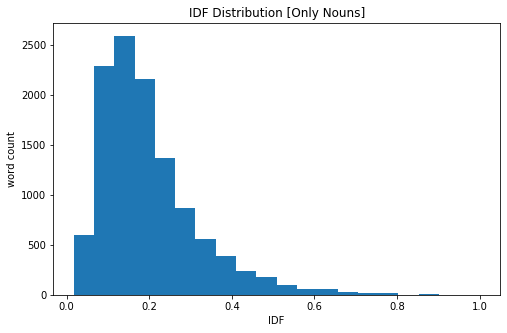

In [67]:
encodings_array = encodings.toarray()
encodings_flat = encodings_array.flatten()
fig, ax = plt.subplots(figsize=(8, 5))
ax.hist(encodings_flat[encodings_flat > 0], bins=20)
ax.set_title('IDF Distribution [Only Nouns]')
ax.set_xlabel('IDF')
ax.set_ylabel('word count')
plt.savefig(os.path.join(PROJECT_PATH, 'images/idf_distribution_only_nouns.png'))
plt.show()

In [0]:
vocab = [x for x,y in vectorizer.vocabulary_.items()]

In [69]:
print(f'The TF-IDF vocabulary size is {len(vocab)} words.')

The TF-IDF vocabulary size is 2618 words.


In [0]:
df_adjacency = pd.DataFrame(columns=vocab, index=vocab, data=0)

In [0]:
corpus_clean = [x.lower() for x in corpus if x.lower() in vocab]

In [0]:
for i, word in enumerate(corpus_clean):
  end = max(0, len(corpus_clean) - (len(corpus_clean) - (i+5)))
  neighbors = corpus_clean[i+1: end]
  if neighbors:
    df_adjacency.loc[word, neighbors] = df_adjacency.loc[word, neighbors] + 1

In [0]:
nx_words = nx.from_numpy_matrix(df_adjacency.values)
ranks = nx.pagerank(nx_words, alpha=.85, tol=.00000001)

In [0]:
rankings_dict = {
    'rank': [],
    'word': []
}

In [0]:
for i, s in enumerate(vocab):
  rankings_dict['rank'].append(ranks[i])
  rankings_dict['word'].append(s)

In [0]:
df_rankings = pd.DataFrame(rankings_dict)
df_rankings.sort_values(by='rank', ascending=False, inplace=True)
df_rankings.index = np.arange(len(df_rankings))

In [77]:
df_rankings.head(n=10)

,rank,word
0,0.017915,food
1,0.012647,place
2,0.010289,good
3,0.009520,order
4,0.009054,time
5,0.009031,service
6,0.007343,restaurant
7,0.005466,chicken
8,0.005181,people
9,0.004600,sauce


Excellent! Now, I have specific things that customers are complaining about. 

Let's explore topic further by generating a few visualizations.

## Bar Plot
I will ranks in a bar plot to display the relative importance between different words. To make plot more pleasing, I will normalize the ranks between 0 and 1.

In [0]:
min_rank = df_rankings['rank'].min()
rank_range = df_rankings['rank'].max() - df_rankings['rank'].min()
df_rankings['norm_rank'] = (df_rankings['rank'] - min_rank) / rank_range

In [79]:
df_rankings.head(n=10)

,rank,word,norm_rank
0,0.017915,food,1.000000
1,0.012647,place,0.704593
2,0.010289,good,0.572379
3,0.009520,order,0.529233
4,0.009054,time,0.503114
5,0.009031,service,0.501823
6,0.007343,restaurant,0.407170
7,0.005466,chicken,0.301901
8,0.005181,people,0.285954
9,0.004600,sauce,0.253361


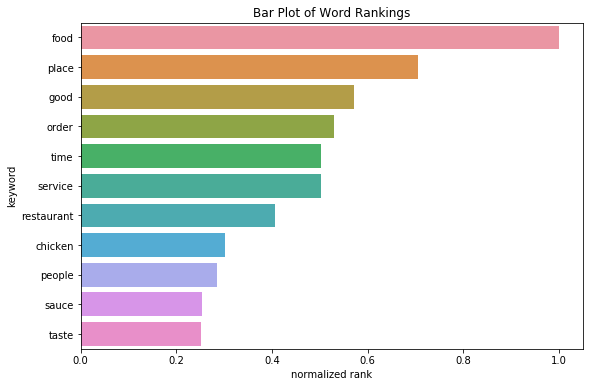

In [80]:
fig, ax = plt.subplots(figsize=(9, 6))
sns.barplot(x='norm_rank', y='word', data=df_rankings.loc[:10,:], ax=ax)
ax.set_xlabel('normalized rank')
ax.set_ylabel('keyword')
ax.set_title('Bar Plot of Word Rankings')
plt.savefig(os.path.join(PROJECT_PATH, 'images/word_rankings_bar_plot.png'))
plt.show()

## Word Cloud
Another way to visualize the importance of words is creating a word cloud. The size of each word in the below image is related to how much that word is used in the corpus.

In [0]:
corpus_string = ' '.join(corpus_clean)

In [0]:
word_cloud = WordCloud(max_font_size=50, max_words=100, background_color="white").generate(corpus_string)

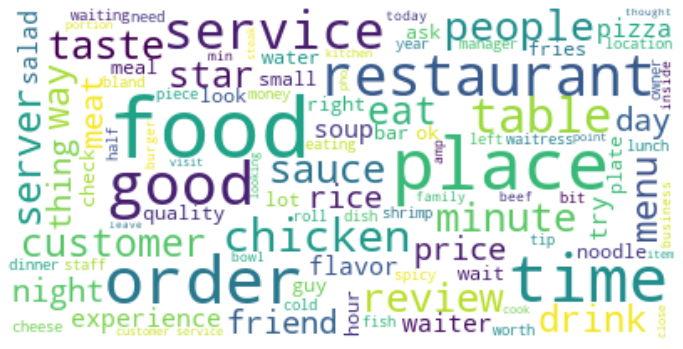

In [83]:
plt.figure(figsize=(12, 7))
plt.imshow(word_cloud, interpolation="bilinear")
plt.axis("off")
plt.savefig(os.path.join(PROJECT_PATH, 'images/word_cloud.png'))
plt.show()

## Summary and Conclusions
This project addressed the question: _How can restaurants be successful in the South Bay?_ I used review data scrapped from Yelp. Then I performed sentiment analysis, using the ratings as labels and the review text as features. The ratings were split into two groups, positive (4-5 stars) and negative (1-2 stars). I tried four different models and concluded that a simple, multi-layer perceptron model performed the best. The negative review predictions for this model were passed on to the topic analysis phase, where I search for trends in the text that related to areas of improvement for restaurants.

I found that the five main areas of improvement are: **food**, **order**, **place**, **service**, and **time**. Food and order imply problems related to the quality of the food. Service and time, seem related to the customer experience. Place could indicate complaints about the ambiance or decour.